# GPU計算必要なときだけロードする

In [27]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5532634856330883502,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2561652894390585191
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5864969355738606043
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10815605965
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12195509047490485476
 physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"]

In [28]:
import tensorflow as tf

gpu_id = 0
print(tf.__version__)
if tf.__version__ >= "2.1.0":
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[gpu_id], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[gpu_id], True)
elif tf.__version__ >= "2.0.0":
    #TF2.0
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(physical_devices[gpu_id], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[gpu_id], True)
else:
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto(
        gpu_options=tf.GPUOptions(
            visible_device_list=str(gpu_id), # specify GPU number
            allow_growth=True
        )
    )
    set_session(tf.Session(config=config))

2.1.0


In [3]:
pwd

'/iida/cnn_galaxy'

## モジュールインポート

In [25]:
import os
import tensorflow as tf
import keras

In [26]:
# Kerasの必要なコンポーネントをインポート
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model

# Scikit-learn(Sklearn)のインポート
#  from sklearn.datasets import fetch_openml

import scipy.stats

# データを高速かつ効率的に使えるPandasをインポート
import pandas as pd
# 数値計算を効率的に行うNumpyをインポート
import numpy as np
#グラフが簡単に描写できるMatplotlibをインポート
import matplotlib
import matplotlib.pyplot as plt

#astropy関連のインポート
from astropy.table import Table

#csv
import csv

# tqdm
from tqdm.notebook import tqdm

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
import datetime
import pydot

In [5]:
 # Clear any logs from previous runs
!rm -rf ./logs/ 

# テスト - 一旦画像表示させてみる

In [5]:
galaxy_arr = np.load("data/npz/587727178986356823.npy")

In [19]:
# 画像
print(galaxy_arr)
print(galaxy_arr.shape)

[[1196 1188 1197 ... 1191 1191 1187]
 [1179 1185 1179 ... 1196 1189 1191]
 [1194 1189 1197 ... 1194 1199 1196]
 ...
 [1188 1189 1194 ... 1187 1202 1186]
 [1179 1189 1190 ... 1199 1195 1205]
 [1196 1196 1189 ... 1187 1189 1185]]
(60, 60)


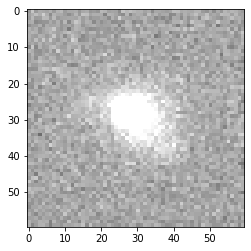

In [7]:
# 画像表示
plt.imshow(np.log10(galaxy_arr.T[::-1, ::-1]), cmap='gray', vmin=3.05, vmax=3.09)

In [17]:
#最大値参照
print(np.argmax(galaxy_arr)) #これは平坦化した際のインデックス
print(np.unravel_index(np.argmax(galaxy_arr),galaxy_arr.shape))
print(galaxy_arr[31,31])

1891
(31, 31)
1516


# データセット生成

## 準備

In [104]:
# 使うデータの数を決定
num_of_data = 10000

In [105]:
# まず、用いる銀河のtableを作成
# とりあえず手動で蹴る
gz_table = []
count = 0
table_hontai = Table.read('GalaxyZoo1_DR_table2.fits',memmap=True)
for i in tqdm(table_hontai):
    if i[0] == 587724198813433876 or i[0] == 587724199349518483:
        print('error')
        continue
    gz_table.append(i)
    count+=1
    if count == num_of_data:
        break


# csv版
# csv_obj = open('data/csv/galaxy_csv.csv')
# csv_reader = csv.reader(csv_obj)
# gz_table = [row for c,row in enumerate(csv_reader) if c < num_of_data]

error
error



In [10]:
# x(画像データ)のロード　(最初からndarrayで用意ver.)
x = np.load('data/npz/' + str(gz_table[0][0]) + '.npy')
x = x.reshape(1,60,60)

for i in tqdm(gz_table[1:len(gz_table)]):
    tmp =  np.load('data/npz/' + str(i[0]) + '.npy')
    tmp = tmp.reshape(1,60,60)
    x = np.append(x,tmp,axis=0)

In [106]:
# x(画像データ)のロード (listに入れてから、ndarrayに変換ver.)前こっちはバグったのに大丈夫になった)
x = [np.load('data/npz/' + str(i[0]) + '.npy') for i in gz_table]

# list → nparray、およびint → float
X = np.array(x)
X = X.astype('float32')

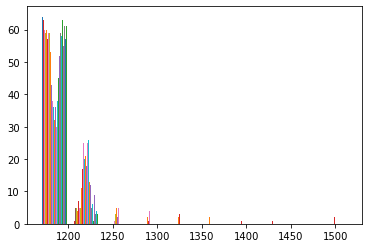

In [114]:
plt.hist(x[0]);plt.show()

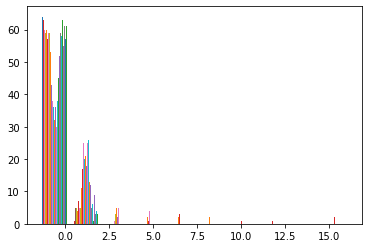

In [113]:
# ヒストグラム出してみる
plt.hist(X[0]);plt.show()

## 正規化

In [23]:
# 正規化(最大値で割っただけ)
for i in range(len(gz_table)):
    idx = np.unravel_index(np.argmax(X[i]), X[i].shape)
    idx_content = X[i][idx]
    X[i] = X[i]/idx_content

In [107]:
# 標準化
for i in range(num_of_data):
    X[i] = scipy.stats.zscore(X[i],axis=None)

In [108]:
# y(正解ラベル)をロード
Y = []
for i in gz_table:
    if i[13] == 1:
        Y.append(0)
    elif i[14] == 1:
        Y.append(1)
    elif i[15] == 1:
        Y.append(2)

In [109]:
# ワンホットエンコーディング
Y = np_utils.to_categorical(Y,3)

In [110]:
# 訓練データとテストデータを切り分ける
X_train, X_test, Y_train, Y_test = X[:8000], X[8000:], Y[:8000], Y[8000:]
Y_test_backup = Y_test

X_train = X_train.reshape(8000, 64, 64, 1)
X_test  = X_test.reshape(2000, 64, 64, 1)

# 両方のサイズを確認
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))

8000
(64, 64, 1)
<class 'numpy.ndarray'>


# モデル構築とトレーニング

In [111]:
# Parameter
batch_size = 64
epochs = 50

# Model Construction                                                                                
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(64, 64, 1)))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(3200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])



# Learning and Score                                                                                
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 60, 60, 32)        832       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 128)        

## history回避、きちんとやる

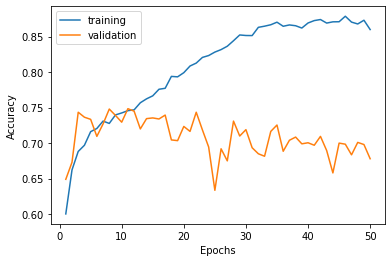

In [112]:
# 可視化
plt.plot(range(1,epochs+1), history.history['accuracy'], label="training")
plt.plot(range(1,epochs+1), history.history['val_accuracy'], label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# tensorboard　(準備中) 
%tensorboard --logdir logs/fit

In [ ]:
# X_testを使って予測を行う
predictions = model.predict_classes(X_test)
xa = list(predictions)
ya = list(Y_test_backup)
results = pd.DataFrame({'Actual': ya, 'Predictions': xa})
results[1:3]
